In [44]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
import time
# Set up the device for GPU usage if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### The following generates synthetic data, which a combination of 3 Gaussian Distributions, with means -2, 0 and 2. 

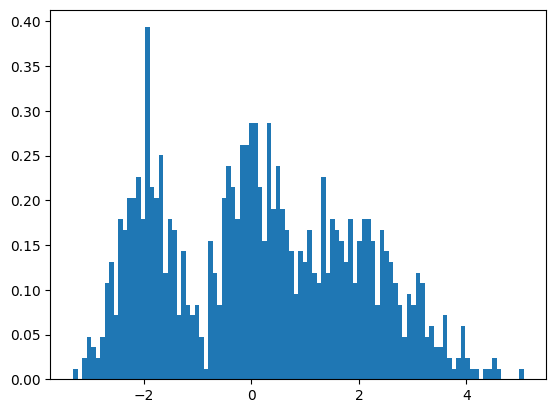

In [45]:
# Generate sample data
data = torch.cat([torch.normal(-2, 0.5, size=(300,)), torch.normal(0, 0.5, size=(300,)), torch.normal(2, 1, size=(400,))]).to(device)
#plot the data
plt.hist(data.cpu().numpy(), bins=100, density=True)
plt.show()

### We initialize k Gaussian kernels, each with randomly assigned mean, variance and weight. 

In [46]:
# Initialize parameters
k = 10  # Number of kernels

mu = torch.randn(k, requires_grad=True, device=device)  # Initial guesses for means
sigma = torch.ones(k, requires_grad=True, device=device)  # Initial guesses for standard deviations
pi = torch.ones(k)/k  # Mixing coefficients
pi.requires_grad = True

<img alt="\Large L = -\sum_{n=1}^{N} \log \left(\sum_{k=1}^{K} \pi_k \cdot \mathcal{N}(x_n | \mu_k, \sigma_k^2)\right)" src="https://latex.codecogs.com/svg.latex?L = -\sum_{n=1}^{N} \log \left(\sum_{k=1}^{K} \pi_k \cdot \mathcal{N}(x_n | \mu_k, \sigma_k^2)\right)">

In [47]:
def log_sum_exp(value):
    """ Numerically stable computation of log sum exp """
    m = torch.max(value, dim=0).values
    return m + torch.log(torch.sum(torch.exp(value - m), dim=0))

def gmm_loss(data, mu, sigma, pi):
    """ Calculate the negative log likelihood of the GMM """
    k = len(pi)
    log_probs = torch.stack([
        dist.Normal(mu[i], sigma[i]).log_prob(data) + torch.log(pi[i])
        for i in range(k)
    ])
    return -torch.sum(log_sum_exp(log_probs))

In [48]:
def plot_gmm(data, mu, sigma, pi, num_points=1000):
    """ Visualize the GMM results along with the data """
    data = data.cpu().numpy()  # Convert data to numpy array for plotting
    mu = mu.detach().cpu().numpy()
    sigma = sigma.detach().cpu().numpy()
    pi = pi.detach().cpu().numpy()
    
    # Create a range of values for plotting the Gaussian functions
    x_values = np.linspace(data.min() - 1, data.max() + 1, num_points)
    
    # Calculate the total density function for the GMM
    total_density = np.zeros_like(x_values)
    for m, s, p in zip(mu, sigma, pi):
        density = p * (1 / (np.sqrt(2 * np.pi) * s)) * np.exp(-0.5 * ((x_values - m) / s)**2)
        total_density += density
        plt.plot(x_values, density, label=f'Component {m:.2f}', linestyle='--')
    
    # Plot the total GMM density
    plt.plot(x_values, total_density, label='Total GMM Density', color='black', linewidth=2)
    
    # Plot the data as a histogram
    plt.hist(data, bins=100, density=True, alpha=0.5, color='gray', label='Data Histogram')
    
    # Add labels and legend
    plt.title('Gaussian Mixture Model Fitting')
    plt.xlabel('Data Values')
    plt.ylabel('Density')
    plt.legend()
    
    plt.show()

Iteration 0, Loss: 2065.327880859375


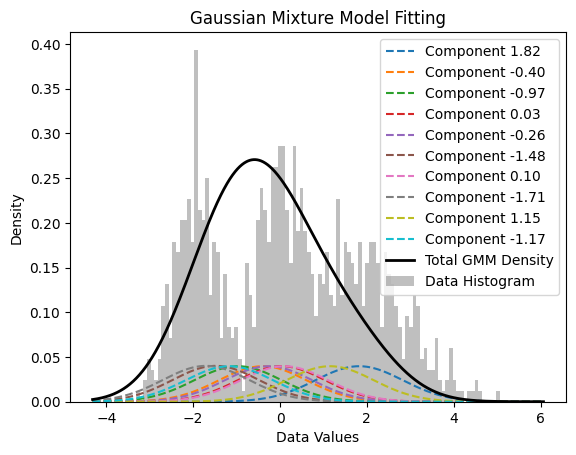

Iteration 100, Loss: 1926.5494384765625


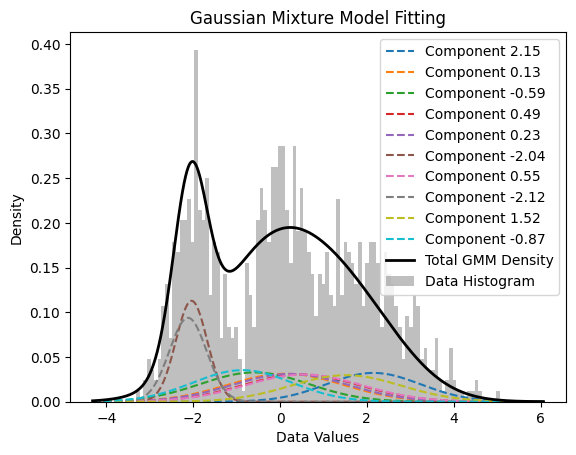

Iteration 200, Loss: 1906.1624755859375


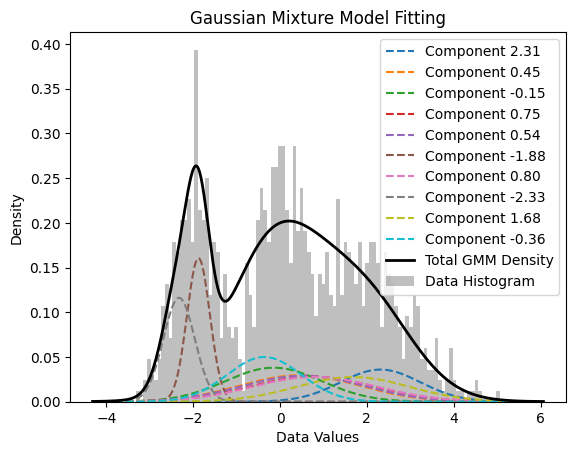

Iteration 300, Loss: 1890.6876220703125


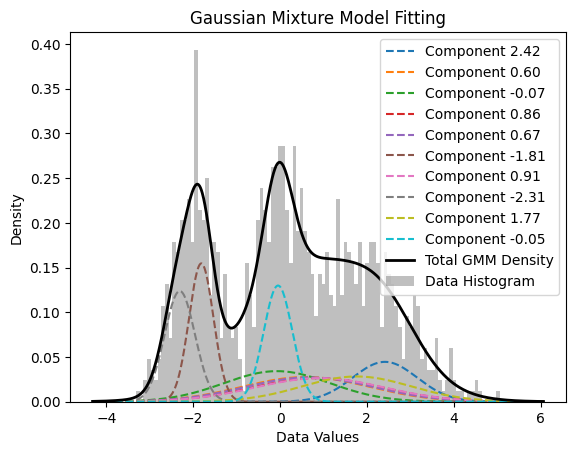

Iteration 400, Loss: 1890.6502685546875


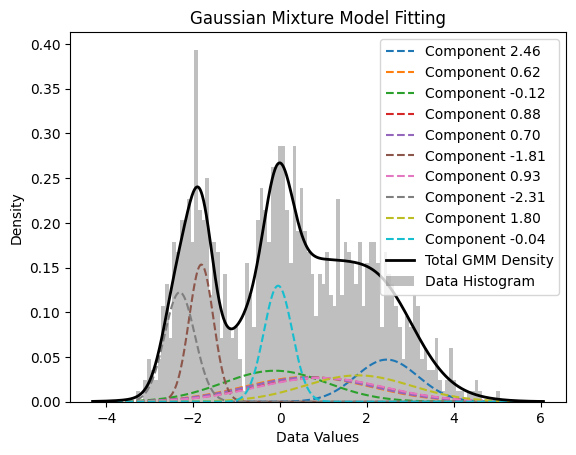

Iteration 500, Loss: 1890.7176513671875


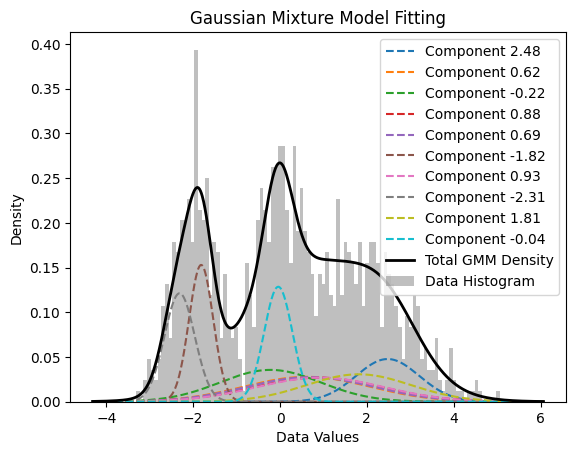

Iteration 600, Loss: 1890.7679443359375


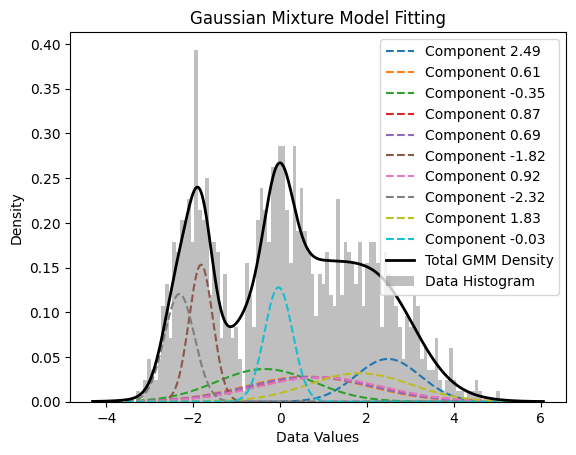

Iteration 700, Loss: 1890.786376953125


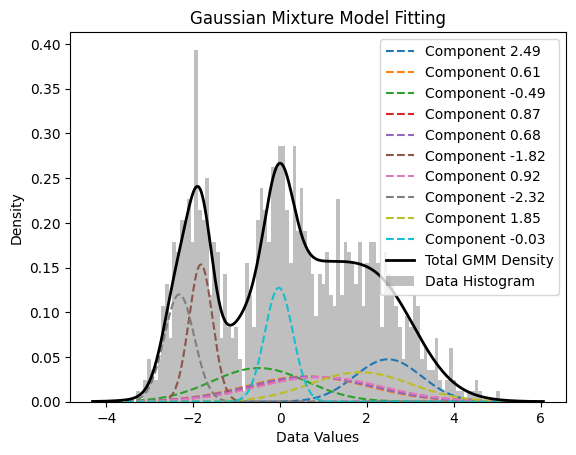

Iteration 800, Loss: 1890.7822265625


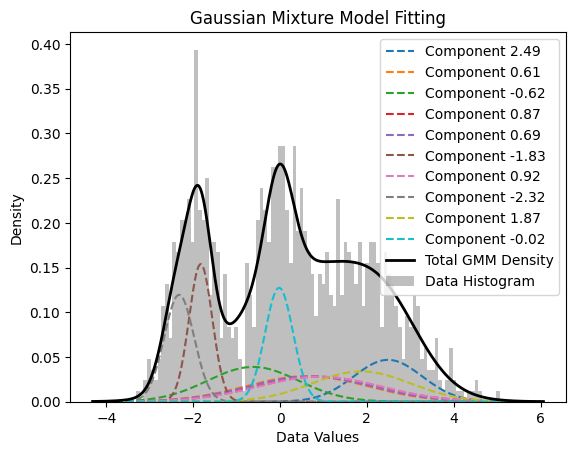

Iteration 900, Loss: 1890.7703857421875


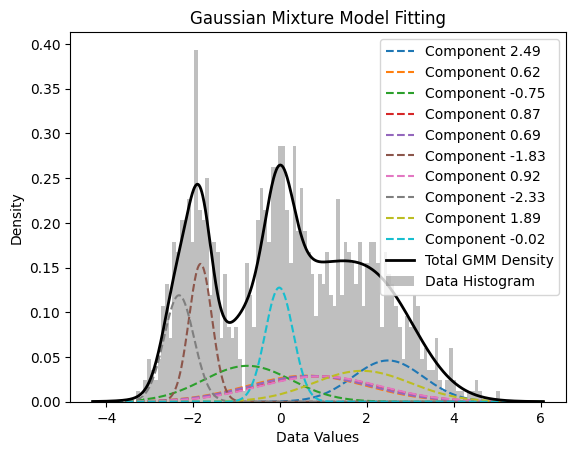

Final estimates:
Means: tensor([ 2.4944,  0.6239, -0.8700,  0.8782,  0.6992, -1.8338,  0.9229, -2.3296,
         1.9059, -0.0160])
Sigmas: tensor([0.8247, 1.3515, 0.9782, 1.3791, 1.3642, 0.2632, 1.3793, 0.3418, 1.1141,
        0.3211])
Mixing coefficients: tensor([0.0944, 0.1005, 0.1014, 0.0999, 0.1004, 0.1017, 0.0998, 0.1016, 0.0973,
        0.1030])


In [49]:
# Training loop
num_iterations = 1000
# Set up the optimizer
optimizer = torch.optim.Adam([mu, sigma, pi], lr=0.005)

for _ in range(num_iterations):
    optimizer.zero_grad()  # Clear gradients
    loss = gmm_loss(data, mu, sigma, pi)
    loss.backward()  # Compute gradients
    optimizer.step()  # Update parameters
    
    # Constrain pi to be a valid probability distribution
    with torch.no_grad():
        pi /= pi.sum()
    
    if _ % 100 == 0:
        print(f"Iteration {_}, Loss: {loss.item()}")
        plot_gmm(data, mu, sigma, pi)
        time.sleep(1)

print("Final estimates:")
print("Means:", mu.data)
print("Sigmas:", sigma.data)
print("Mixing coefficients:", pi.data)

In [ ]:
# Assuming 'data', 'mu', 'sigma', 'pi' are already defined from the previous example
plot_gmm(data, mu, sigma, pi)